# Benchmark results on Emmy

In [1]:
import json

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

PROM_RESULT_PATH = "./prometheus/results.json"
PROM_VMSTAT_PATH = "./prometheus/vmstat.json"
PATCHED_NODE_EXP_PATH = "./patched_node_exporter/total_times.json"
NODE_EXP_PATH = "./node_exporter/parsed.json"

def load_json(path):
    with open(path, "r") as fp:
        return json.load(fp)

PROM_RESULT = load_json(PROM_RESULT_PATH)
PROM_VMSTAT = load_json(PROM_VMSTAT_PATH)
PATCHED_NODE_EXP = load_json(PATCHED_NODE_EXP_PATH)
NODE_EXP = load_json(NODE_EXP_PATH)

## Patched Node Exporter

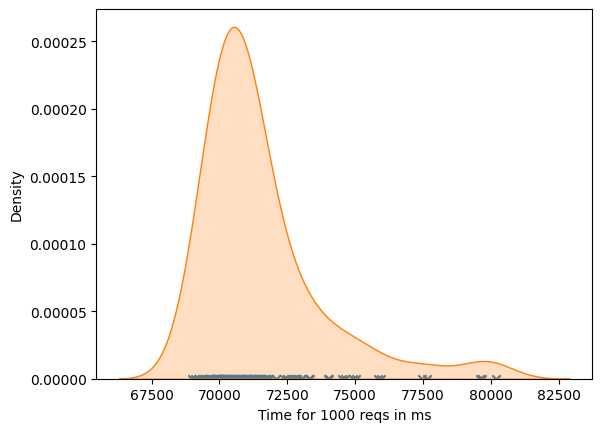

In [2]:
fig, ax = plt.subplots()
ax.scatter(PATCHED_NODE_EXP, np.zeros_like(PATCHED_NODE_EXP), marker='x')
sns.kdeplot(PATCHED_NODE_EXP, ax=ax, fill=True)
plt.xlabel('Time for 1000 reqs in ms')
plt.show()

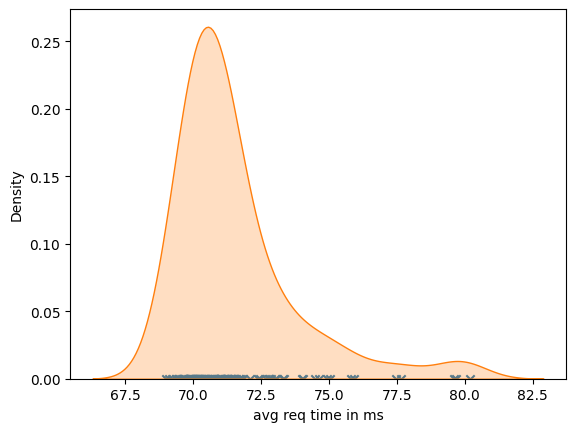

In [3]:
single_req = [n/1000 for n in PATCHED_NODE_EXP]
fig, ax = plt.subplots()
ax.scatter(single_req, np.zeros_like(single_req), marker='x')
sns.kdeplot(single_req, ax=ax, fill=True)
plt.xlabel('avg req time in ms')
plt.show()

## Node Exporter

In [4]:
SEQUENTIAL = NODE_EXP['sequential']
PARALLEL_GO = NODE_EXP['parallel_go']
PARALLEL_WRK = NODE_EXP['parallel_wrk']

SEQUENTIAL['output']['1']

[{'time': '1m',
  'threads': '1',
  'connections': '10',
  'latency_avg': '257.73us',
  'latency_stdev': '0.87ms',
  'latency_max': '46.49ms',
  'reqsec_avg': '43.99k',
  'reqsec_stdev': '3.75k',
  'reqsec_max': '50.46k',
  'total_reqs': '2630421',
  'amount': '2.64GB',
  'reqs_sec': '43767.79',
  'transfer_sec': '45.00MB'}]

dict structure:
{
  "time": "1m",
  "threads": "1",
  "connections": "10",
  "latency_avg": "257.73us",
  "latency_stdev": "0.87ms",
  "latency_max": "46.49ms",
  "reqsec_avg": "43.99k",
  "reqsec_stdev": "3.75k",
  "reqsec_max": "50.46k",
  "total_reqs": "2630421",
  "amount": "2.64GB",
  "reqs_sec": "43767.79",
  "transfer_sec": "45.00MB"
}


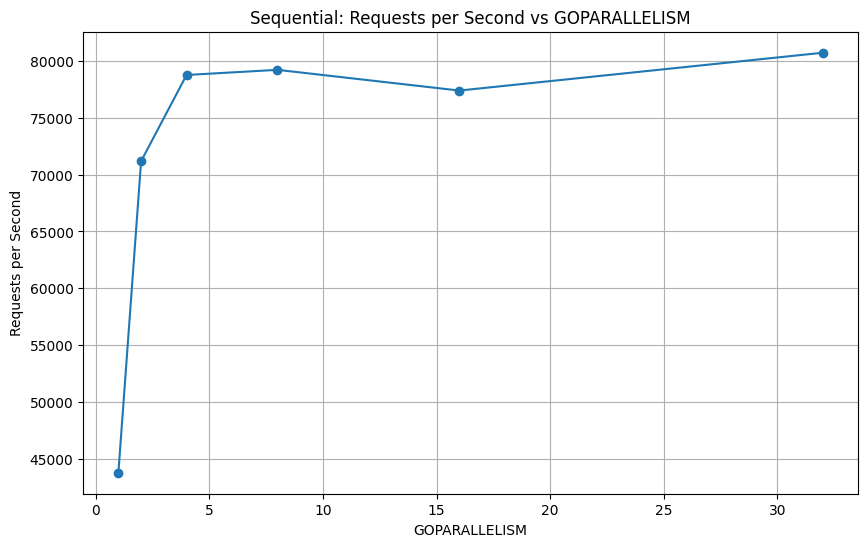

In [5]:
def transform_dict(sequential):
    """
    Transforms a dictionary with string keys and single-element list values
    into a dictionary with integer keys and the first element of the list as values.
    """
    transformed_dict = {}
    for key, value in sequential.items():
        # Convert the key to an integer
        int_key = int(key)

        # Assert that the value is a one-element list
        assert len(value) == 1, f"List at key '{key}' does not have exactly one element."

        # Assign the first element of the list as the value for the new key
        transformed_dict[int_key] = value[0]

    return transformed_dict

SEQUENTIAL_OUTPUT = transform_dict(SEQUENTIAL['output'])
SEQUENTIAL_OUTPUT
print("dict structure:")
print(json.dumps(SEQUENTIAL_OUTPUT[1], indent=2))

# Sorting data by key (GOPARALLELISM) and extracting X (key) and Y (reqs_sec) values
sorted_keys = sorted(SEQUENTIAL_OUTPUT.keys())
reqs_sec_values = [float(SEQUENTIAL_OUTPUT[key]['reqs_sec']) for key in sorted_keys]
amount = [float(SEQUENTIAL_OUTPUT[key]['amount'].split("GB")[0]) for key in sorted_keys]

plt.figure(figsize=(10, 6))
plt.plot(sorted_keys, reqs_sec_values, marker='o')
plt.xlabel('GOPARALLELISM')
plt.ylabel('Requests per Second')
plt.title('Sequential: Requests per Second vs GOPARALLELISM')
plt.grid(True)
plt.show()


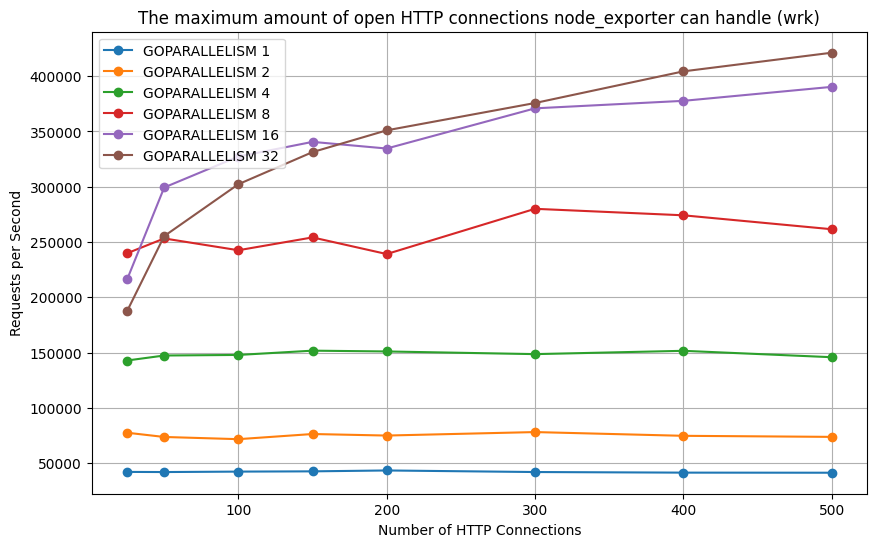

In [22]:
# node exporter:
# - parallel: for all threads+go, put the line of scaling up the number of connections/goroutines
#             create a second one with only go + the best performing wrk.
#             Do that for a single threaded node exporter
#             For the best go and wrk throughput, also plot GORUNTIME as X-axis


plt.figure(figsize=(10, 6))
for goparallelism in sorted(PARALLEL_WRK['output'], key=lambda x: int(x)):
    connection_performance = []
    for measurement in PARALLEL_WRK['output'][goparallelism]:
        # we first only look at threads=16
        if measurement['threads'] != '16':
            continue
        connection_performance.append((int(measurement['connections']), float(measurement['reqs_sec'])))
    connection_performance.sort(key=lambda x:x[0])
    
    plt.plot(*zip(*connection_performance), label=f"GOPARALLELISM {goparallelism}", marker='o')

plt.xlabel('Number of HTTP Connections')
plt.ylabel('Requests per Second')
plt.title('The maximum amount of open HTTP connections node_exporter can handle (wrk)')
plt.legend()
plt.grid(True)
plt.show()

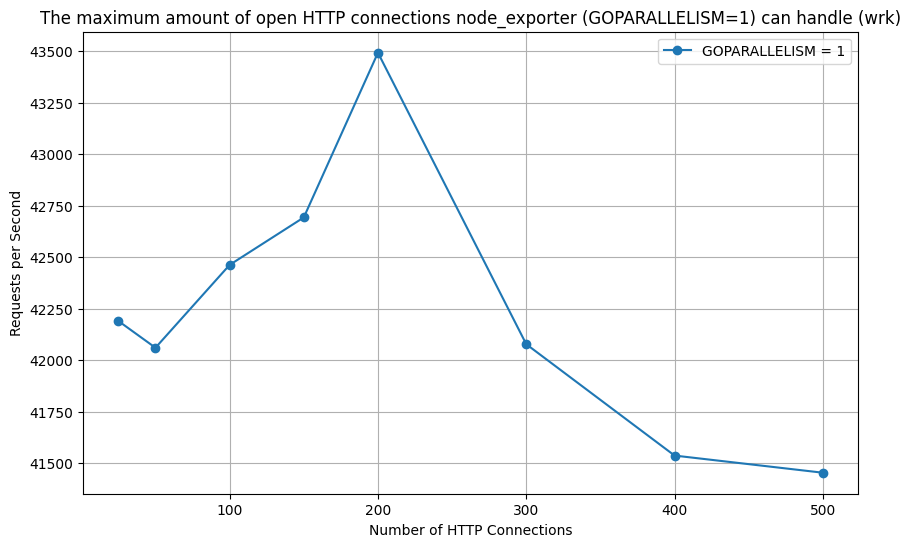

In [24]:
plt.figure(figsize=(10, 6))
connection_performance = []
for measurement in PARALLEL_WRK['output']['1']:
    # we first only look at threads=16
    if measurement['threads'] != '16':
        continue
    connection_performance.append((int(measurement['connections']), float(measurement['reqs_sec'])))
connection_performance.sort(key=lambda x:x[0])    
plt.plot(*zip(*connection_performance), label=f"GOPARALLELISM = 1", marker='o')

plt.xlabel('Number of HTTP Connections')
plt.ylabel('Requests per Second')
plt.title('The maximum amount of open HTTP connections node_exporter (GOPARALLELISM=1) can handle (wrk)')
plt.legend()
plt.grid(True)
plt.show()

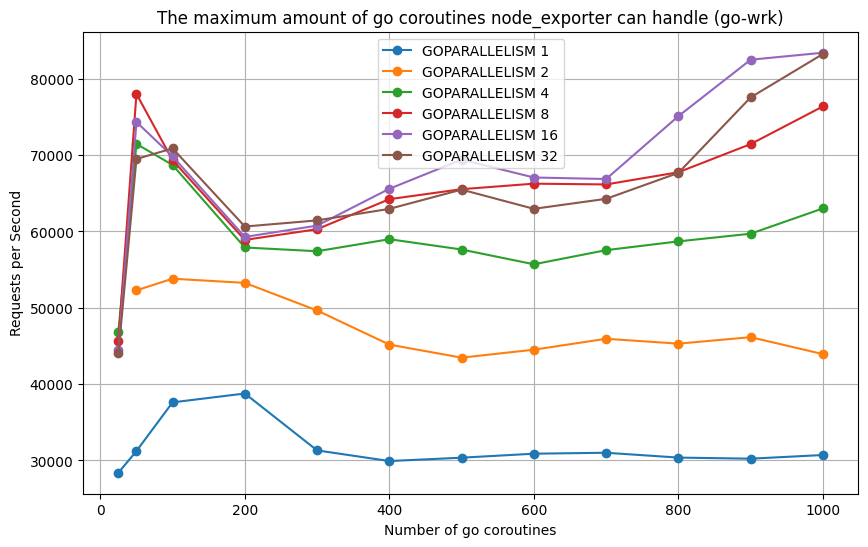

In [21]:
plt.figure(figsize=(10, 6))
for goparallelism in sorted(PARALLEL_GO['output'], key=lambda x: int(x)):
    connection_performance = []
    for measurement in PARALLEL_GO['output'][goparallelism]:
        connection_performance.append((int(measurement['goroutines']), float(measurement['reqs_sec'])))
    connection_performance.sort(key=lambda x:x[0])
    
    plt.plot(*zip(*connection_performance), label=f"GOPARALLELISM {goparallelism}", marker='o')

plt.xlabel('Number of go coroutines')
plt.ylabel('Requests per Second')
plt.title('The maximum amount of go coroutines node_exporter can handle (go-wrk)')
plt.legend()
plt.grid(True)

In [26]:
# Assuming PARALLEL_WRK['output'] is a dictionary where keys are GOPARALLELISM values
# and values are lists of dictionaries with 'threads', 'connections', and 'reqs_sec'

# Prepare data for plotting
goparallelism_values = []
reqs_sec_values = []

for goparallelism in sorted(PARALLEL_WRK['output'], key=lambda x: int(x)):
    for measurement in PARALLEL_WRK['output'][goparallelism]:
        # Filter for threads=16 and connections=500
        if measurement['threads'] == '16' and int(measurement['connections']) == 500:
            goparallelism_values.append(int(goparallelism))
            reqs_sec_values.append(float(measurement['reqs_sec']))
            break  # Assuming only one entry per goparallelism value

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(goparallelism_values, reqs_sec_values,, marker='o')

plt.xlabel('GOPARALLELISM')
plt.ylabel('Requests per Second')
plt.title('Maximal (wrk, Threads=16, Connections=500) requests per second')
plt.legend()
plt.grid(True)
plt.show()


SyntaxError: invalid syntax (112748351.py, line 18)

## Prometheus

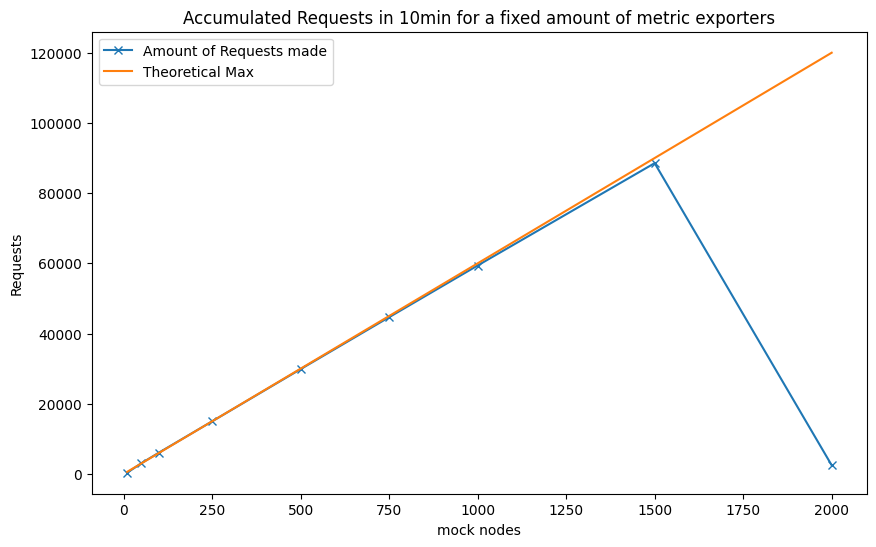

In [8]:
# Get the amount of total requests per second
# Also compute the maximal one
total_amount_of_requests = []
theoretical_maxima = []
for number_of_mock_clients in PROM_RESULT.keys():
    actual_reqs = sum(PROM_RESULT[number_of_mock_clients])
    # maximum: 6 per minute, 10 minutes
    number_of_mock_clients = int(number_of_mock_clients)
    theoretical_max = number_of_mock_clients * 60

    total_amount_of_requests.append((number_of_mock_clients, actual_reqs))
    theoretical_maxima.append((number_of_mock_clients, theoretical_max))


total_amount_of_requests.sort(key=lambda x: x[0])
theoretical_maxima.sort(key=lambda x: x[0])
plt.figure(figsize=(10, 6))
plt.plot(*zip(*total_amount_of_requests), marker='x', label="Amount of Requests made")
plt.plot(*zip(*theoretical_maxima), label="Theoretical Max")
plt.xlabel('mock nodes')
plt.ylabel('Requests')
plt.title('Accumulated Requests in 10min for a fixed amount of metric exporters')
plt.legend()
plt.show()


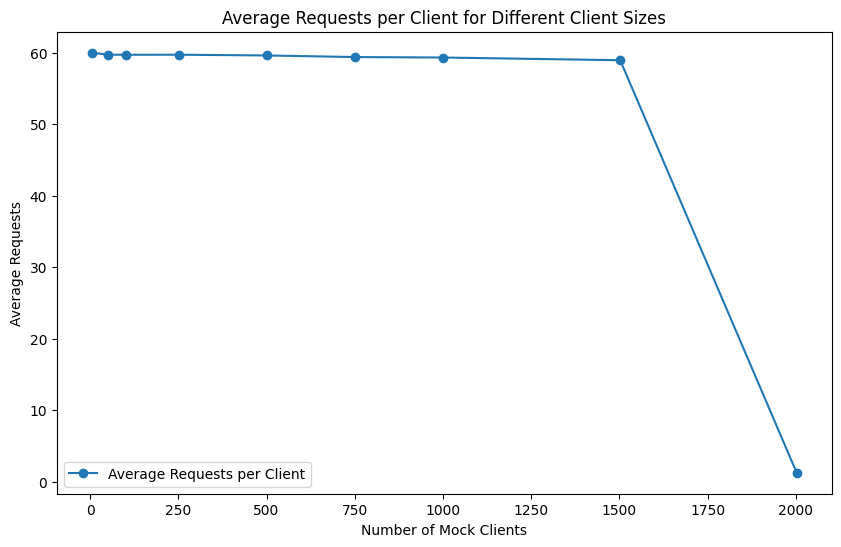

In [9]:
# Calculate the average amount of requests per client
average_requests_per_client = []
for number_of_mock_clients, requests in PROM_RESULT.items():
    number_of_mock_clients = len(requests)
    average_reqs = sum(requests) / number_of_mock_clients
    average_requests_per_client.append((number_of_mock_clients, average_reqs))

# Sort the results
average_requests_per_client.sort(key=lambda x: x[0])

# Plotting the average amount of requests per client
plt.figure(figsize=(10, 6))
plt.plot(*zip(*average_requests_per_client), marker='o', label="Average Requests per Client")
plt.xlabel('Number of Mock Clients')
plt.ylabel('Average Requests')
plt.title('Average Requests per Client for Different Client Sizes')
plt.legend()
plt.show()

### What happened at $n=2000$?

We now want to find out what went so drastically different on 1500 vs 2000.
For that, we check for the following possible bottlenecks:
- **IO:** Due to our recorded 

In [10]:
# Convert PROM_VMSTAT into integers
PROM_VMSTAT = {int(k):v for k,v in PROM_VMSTAT.items()}
for num_mock_clients in PROM_VMSTAT.keys():
    for d in PROM_VMSTAT[num_mock_clients]:
        for k,v in d.items():
            d[k] = v

VMSTAT_1500 = PROM_VMSTAT[1500]
VMSTAT_2000 = PROM_VMSTAT[2000]

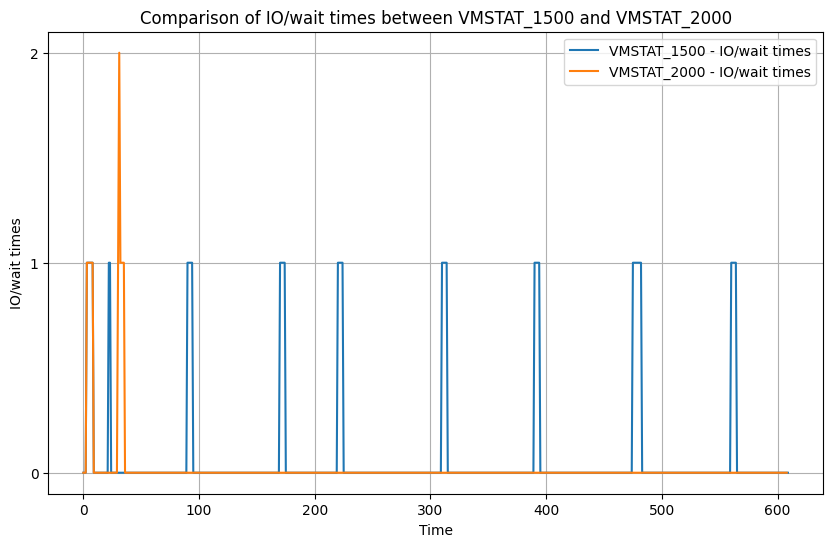

In [11]:
# Extracting the 'wa' (IO/wait times) values for both experiments
wa_values_1500 = [entry['wa'] for entry in VMSTAT_1500]
wa_values_2000 = [entry['wa'] for entry in VMSTAT_2000]

# Plotting the IO/wait times for both experiments
plt.figure(figsize=(10, 6))
plt.plot(wa_values_1500, label='VMSTAT_1500 - IO/wait times')
plt.plot(wa_values_2000, label='VMSTAT_2000 - IO/wait times')
plt.xlabel('Time')
plt.ylabel('IO/wait times')
plt.title('Comparison of IO/wait times between VMSTAT_1500 and VMSTAT_2000')
plt.legend()
plt.grid(True)
plt.show()

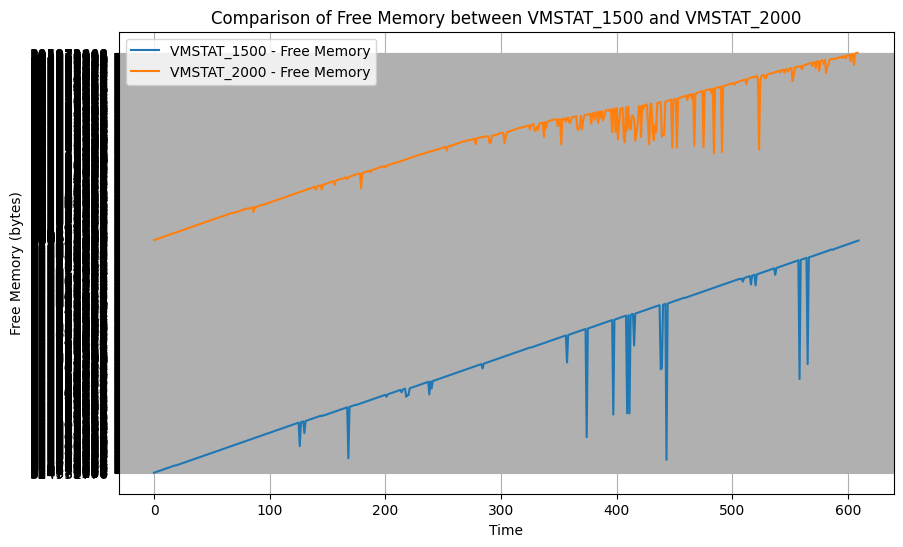

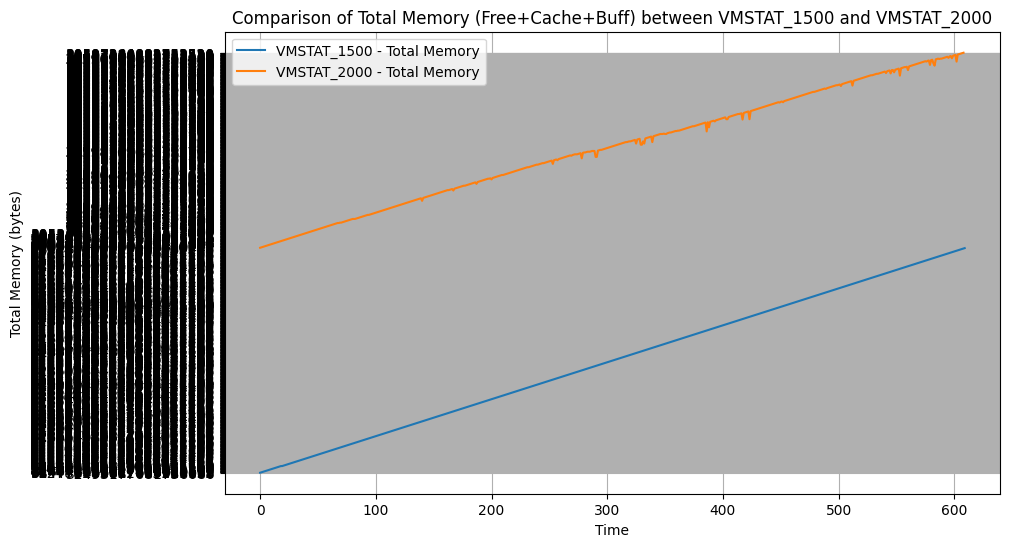

In [12]:
# Extracting memory usage data (free memory, free+cache+buff) for both experiments
free_memory_1500 = [entry['free'] for entry in VMSTAT_1500]
total_memory_1500 = [entry['free'] + entry['cache'] + entry['buff'] for entry in VMSTAT_1500]

free_memory_2000 = [entry['free'] for entry in VMSTAT_2000]
total_memory_2000 = [entry['free'] + entry['cache'] + entry['buff'] for entry in VMSTAT_2000]

# Plotting free memory for both experiments
plt.figure(figsize=(10, 6))
plt.plot(free_memory_1500, label='VMSTAT_1500 - Free Memory')
plt.plot(free_memory_2000, label='VMSTAT_2000 - Free Memory')
plt.xlabel('Time')
plt.ylabel('Free Memory (bytes)')
plt.title('Comparison of Free Memory between VMSTAT_1500 and VMSTAT_2000')
plt.legend()
plt.grid(True)
plt.show()

# Plotting total memory (free+cache+buff) for both experiments
plt.figure(figsize=(10, 6))
plt.plot(total_memory_1500, label='VMSTAT_1500 - Total Memory')
plt.plot(total_memory_2000, label='VMSTAT_2000 - Total Memory')
plt.xlabel('Time')
plt.ylabel('Total Memory (bytes)')
plt.title('Comparison of Total Memory (Free+Cache+Buff) between VMSTAT_1500 and VMSTAT_2000')
plt.legend()
plt.grid(True)
plt.show()


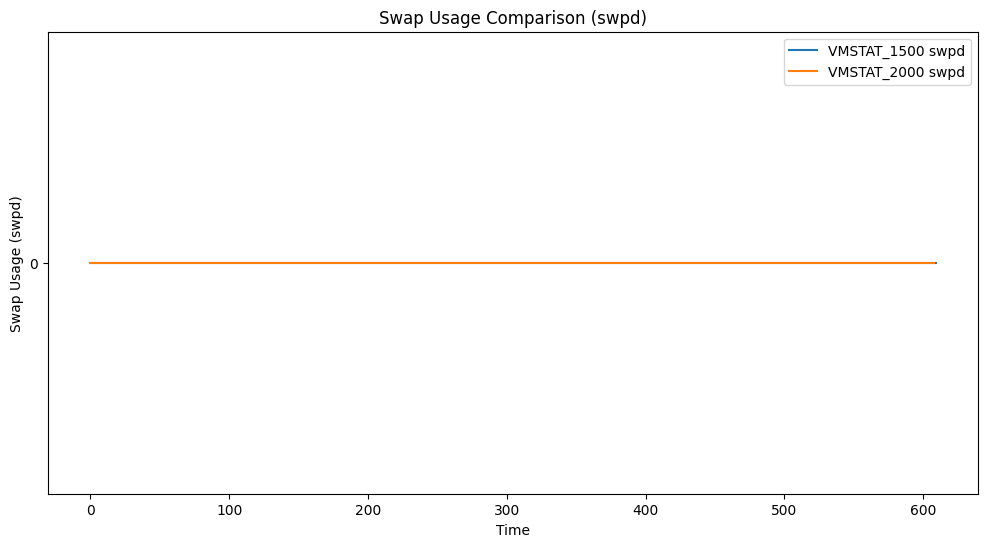

In [13]:
# Comparing swap usage (swpd) for both VMSTAT_1500 and VMSTAT_2000
swpd_1500 = [item['swpd'] for item in VMSTAT_1500]
swpd_2000 = [item['swpd'] for item in VMSTAT_2000]

# Plotting swap usage comparison
plt.figure(figsize=(12, 6))
plt.plot(swpd_1500, label='VMSTAT_1500 swpd')
plt.plot(swpd_2000, label='VMSTAT_2000 swpd')
plt.title('Swap Usage Comparison (swpd)')
plt.xlabel('Time')
plt.ylabel('Swap Usage (swpd)')
plt.legend()
plt.show()

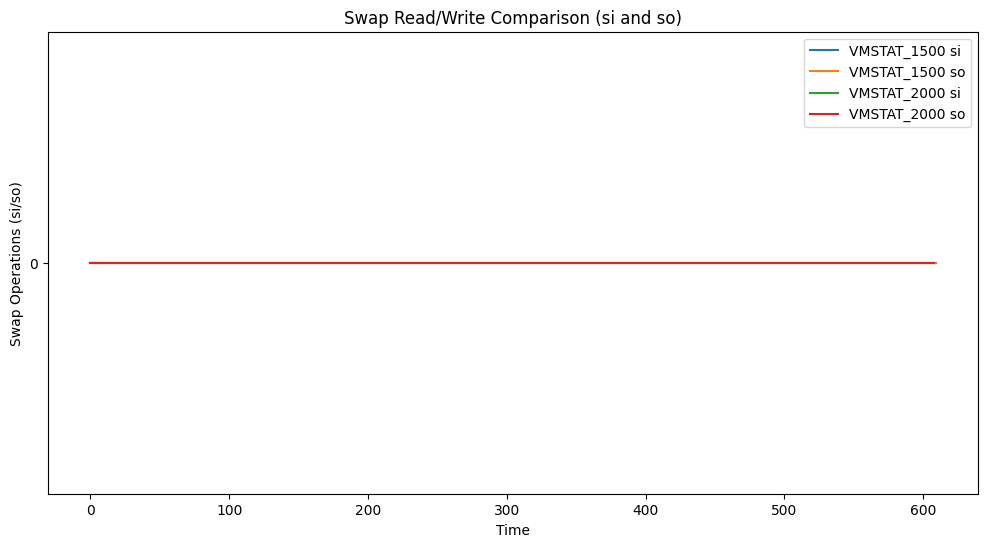

In [14]:
# Comparing swap read and write (si and so) for both VMSTAT_1500 and VMSTAT_2000
si_1500 = [item['si'] for item in VMSTAT_1500]
so_1500 = [item['so'] for item in VMSTAT_1500]
si_2000 = [item['si'] for item in VMSTAT_2000]
so_2000 = [item['so'] for item in VMSTAT_2000]

# Plotting swap read and write comparison
plt.figure(figsize=(12, 6))
plt.plot(si_1500, label='VMSTAT_1500 si')
plt.plot(so_1500, label='VMSTAT_1500 so')
plt.plot(si_2000, label='VMSTAT_2000 si')
plt.plot(so_2000, label='VMSTAT_2000 so')
plt.title('Swap Read/Write Comparison (si and so)')
plt.xlabel('Time')
plt.ylabel('Swap Operations (si/so)')
plt.legend()
plt.show()

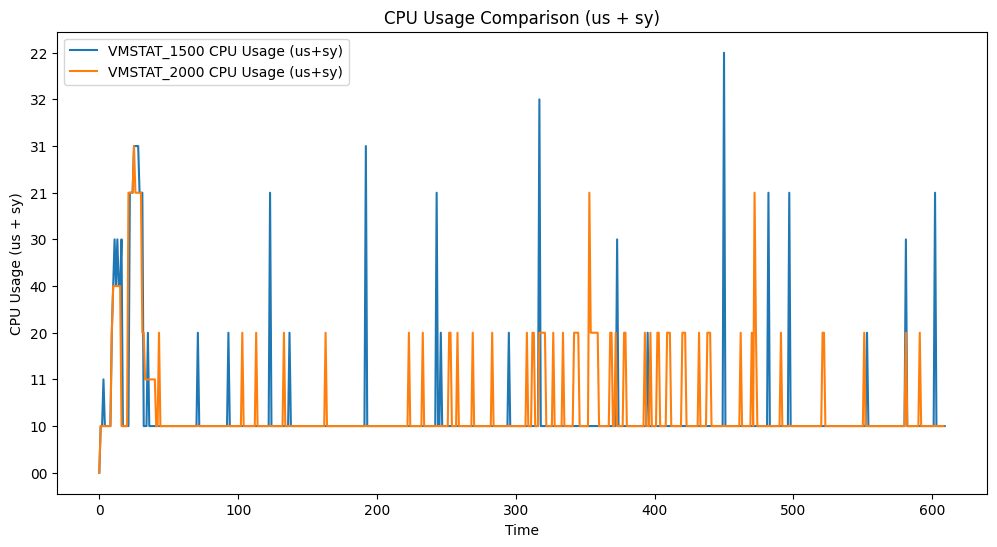

In [15]:
# Comparing CPU usage (us + sy) for both VMSTAT_1500 and VMSTAT_2000
cpu_1500 = [item['us'] + item['sy'] for item in VMSTAT_1500]
cpu_2000 = [item['us'] + item['sy'] for item in VMSTAT_2000]

# Plotting CPU usage comparison
plt.figure(figsize=(12, 6))
plt.plot(cpu_1500, label='VMSTAT_1500 CPU Usage (us+sy)')
plt.plot(cpu_2000, label='VMSTAT_2000 CPU Usage (us+sy)')
plt.title('CPU Usage Comparison (us + sy)')
plt.xlabel('Time')
plt.ylabel('CPU Usage (us + sy)')
plt.legend()
plt.show()